In [18]:
from PIL import Image
import tempfile
import cv2 as cv
import numpy as np
import imutils
%matplotlib inline
from matplotlib import pyplot as plt

In [13]:
def set_300_dpi(img=None, file_path=None, save=True, name='default.png'):
    if img is not None:
        # img has to be PIL format
        image = img
    else:
        image = Image.open(file_path) 
    
#     length_x, width_y = image.size

    # upscales to 300dpi
    size = (6400, 10667)
    im_resized = image.resize(size, Image.ANTIALIAS)

    if save:
        im_resized.save(name, format='png', dpi=(300, 300))
        
    return im_resized

In [21]:
# src	Input 8-bit 1-channel, 2-channel, 3-channel or 4-channel image.
# dst	Output image with the same size and type as src .
# templateWindowSize	Size in pixels of the template patch that is used to compute weights. Should be odd. Recommended value 7 pixels
# searchWindowSize	Size in pixels of the window that is used to compute weighted average for given pixel. Should be odd. Affect performance linearly: greater searchWindowsSize - greater denoising time. Recommended value 21 pixels
# h	Parameter regulating filter strength. Big h value perfectly removes noise but also removes image details, smaller h value preserves details but also preserves some noise
def denoise(img, strength=3, output=None, templateWindowSize=7, searchWindowSize=21):
    return cv.fastNlMeansDenoising(img, output, strength, templateWindowSize, searchWindowSize)

In [22]:
def img_open_cv(path, gray=False):
    if gray:
        image = cv.imread(path, 0)
    else:
        image = cv.imread(path)
    return image

In [24]:
def img_save_cv(img, name):
    cv.imwrite(name, img)

In [26]:
def erode(img, kernel_size=2):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv.erode(img, kernel)

def dilate(img, kernel_size=2):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv.dilate(img, kernel)

In [29]:
def debug_display_cv_img(img):
    cv.namedWindow('image', cv2.WINDOW_AUTOSIZE)
    cv.imshow('image', img)
    cv.waitKey(0)
    cv.destroyWindow('image')

In [50]:
def debug_plot_cv_img(img, cmap=None):
    fig, ax = plt.subplots(figsize=(10, 22))
    ax.imshow(img, interpolation='nearest', cmap=cmap)
    plt.tight_layout()

In [57]:
def to_binary(img, blockSize=11, constant=2):
    gray = cv.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary = cv.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, constant)
    return binary

In [54]:
def get_spectrum(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return 20*np.log(np.abs(fshift))

In [60]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [61]:
def clip_spectrum(img, radius=550):
    h, w = img.shape[:2]
    mask = create_circular_mask(h, w, radius=radius)
    masked_img = img.copy()
    masked_img[~mask] = 0
    return masked_img

In [75]:
def remove_grid(img, line_length=0.05):
    img = cv.bitwise_not(img)
    horizontal = np.copy(img)
    vertical = np.copy(img)

    cols = horizontal.shape[1]
    horizontal_size = cols // (int(cols * line_length))
    # Create structure element for extracting horizontal lines through morphology operations
    horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
    # Apply morphology operations
    horizontal = cv.erode(horizontal, horizontalStructure)
    horizontal = cv.dilate(horizontal, horizontalStructure)

    # Specify size on vertical axis
    rows = vertical.shape[0]
    verticalsize = rows // (int(rows * line_length))
    # Create structure element for extracting vertical lines through morphology operations
    verticalStructure = cv.getStructuringElement(cv.MORPH_RECT, (1, verticalsize))
    # Apply morphology operations
    vertical = cv.erode(vertical, verticalStructure)
    vertical = cv.dilate(vertical, verticalStructure)
    
    out = img - horizontal - vertical
    return out

In [23]:
set_300_dpi(file_path='org.jpg')
img = img_open_cv('default.png')
img = denoise(img)

In [25]:
img_save_cv(img, 'big_denoise.png')

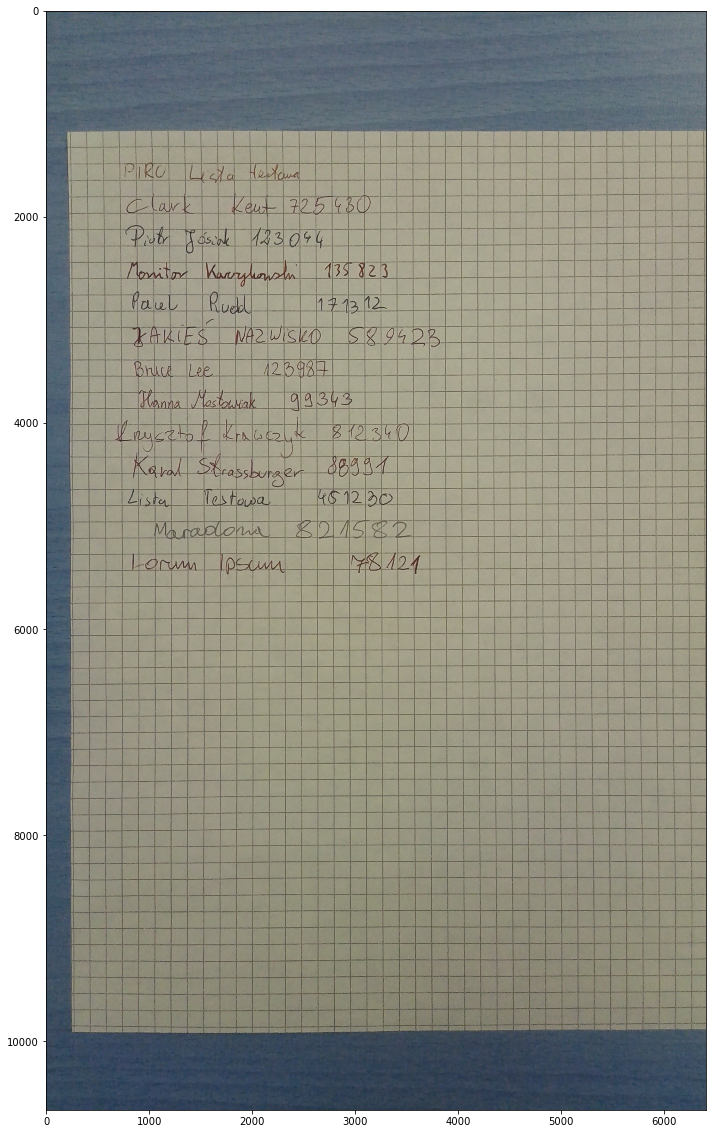

In [52]:
debug_plot_cv_img(img)

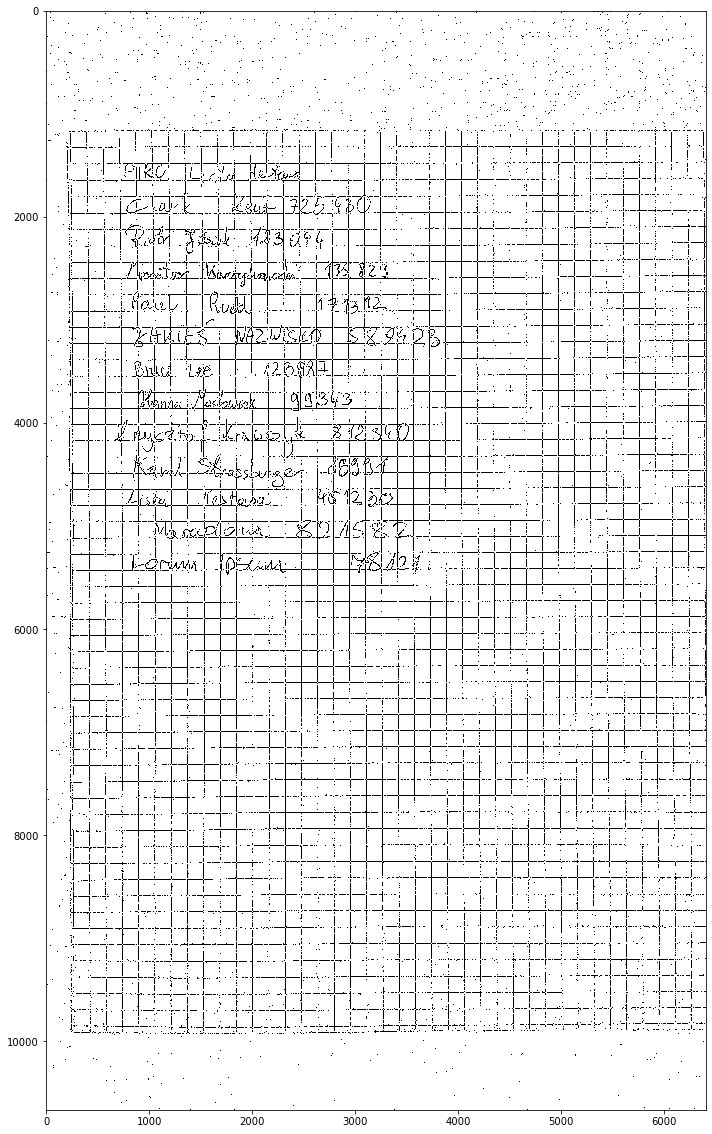

In [51]:
bina = to_binary(img)
debug_plot_cv_img(bina, cmap='gray')

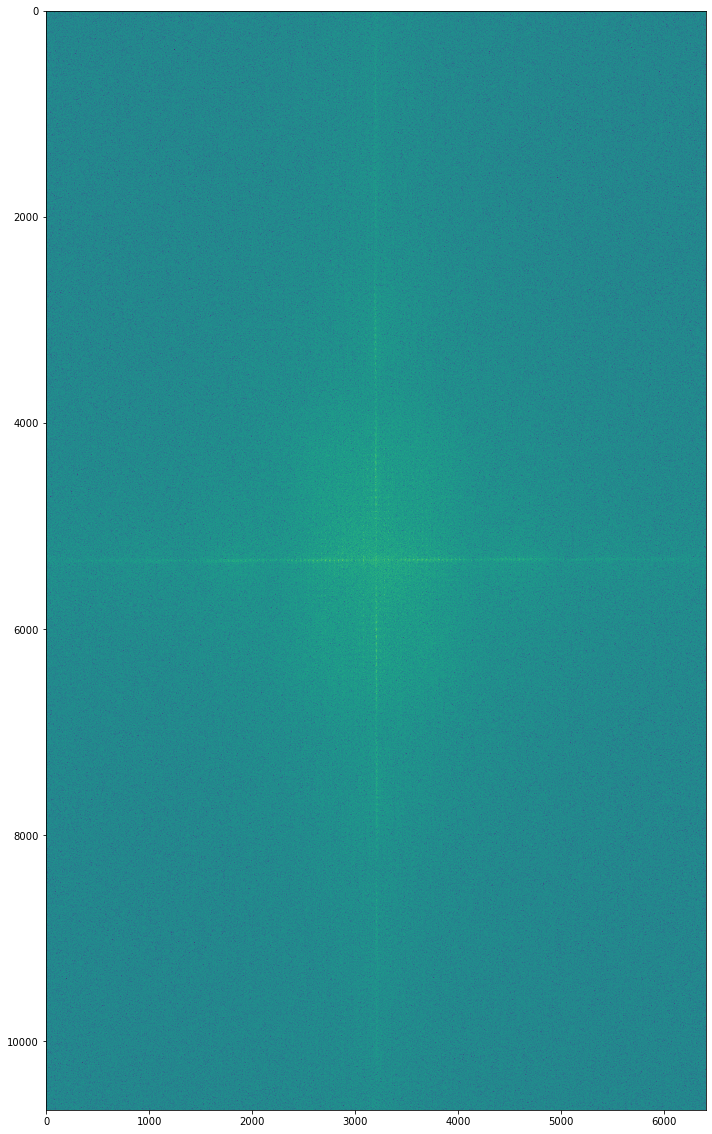

In [55]:
spectrum = get_spectrum(bina)
debug_plot_cv_img(spectrum)

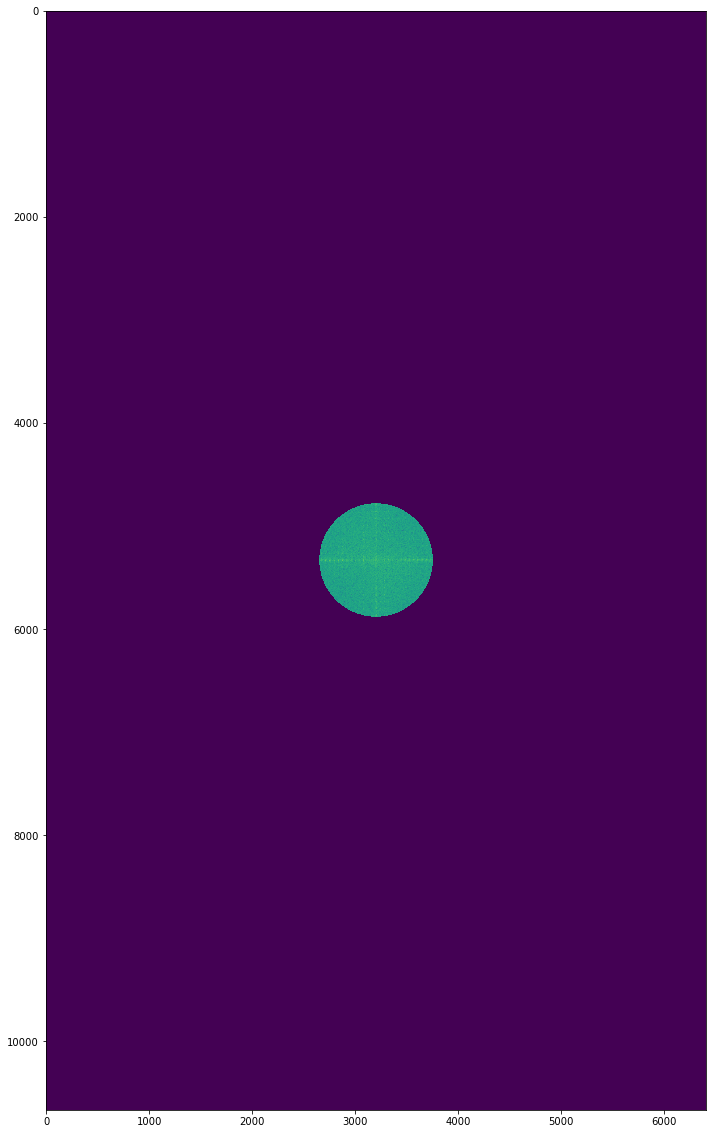

In [62]:
clipped_spectrum = clip_spectrum(spectrum)
debug_plot_cv_img(clipped_spectrum)

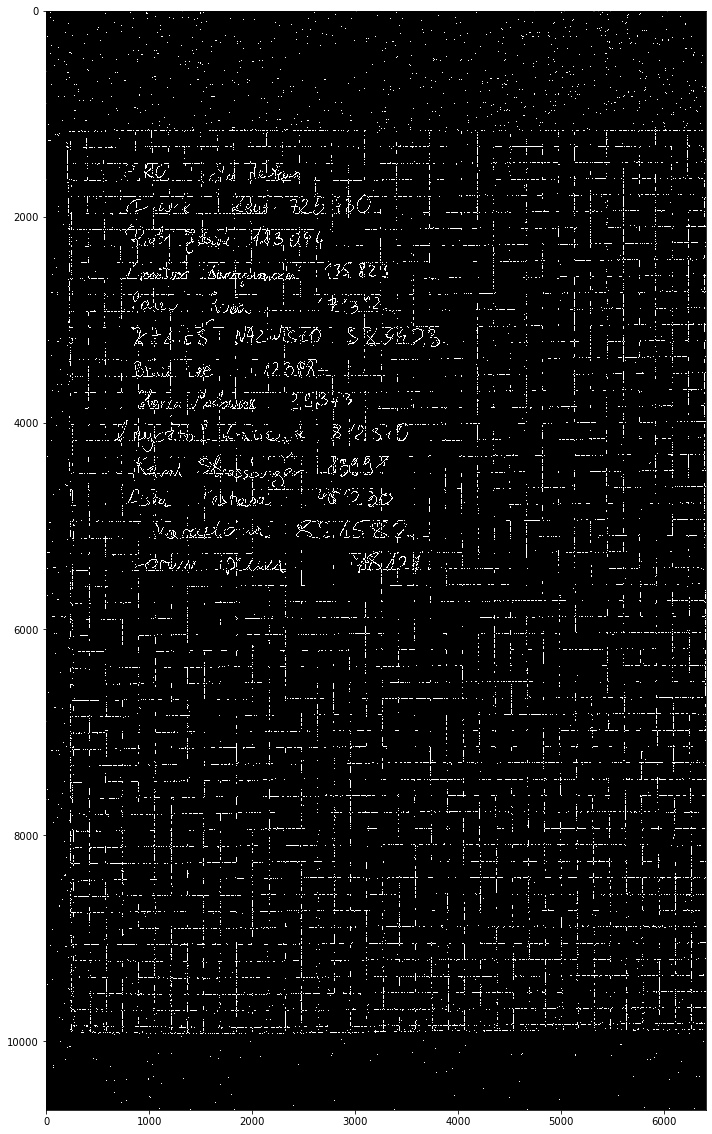

In [88]:
# grid = cv.GaussianBlur(bina, (10, 10), 0)
grid = remove_grid(bina, 0.02)
debug_plot_cv_img(grid, cmap='gray')
img_save_cv(grid, 'debug.png')

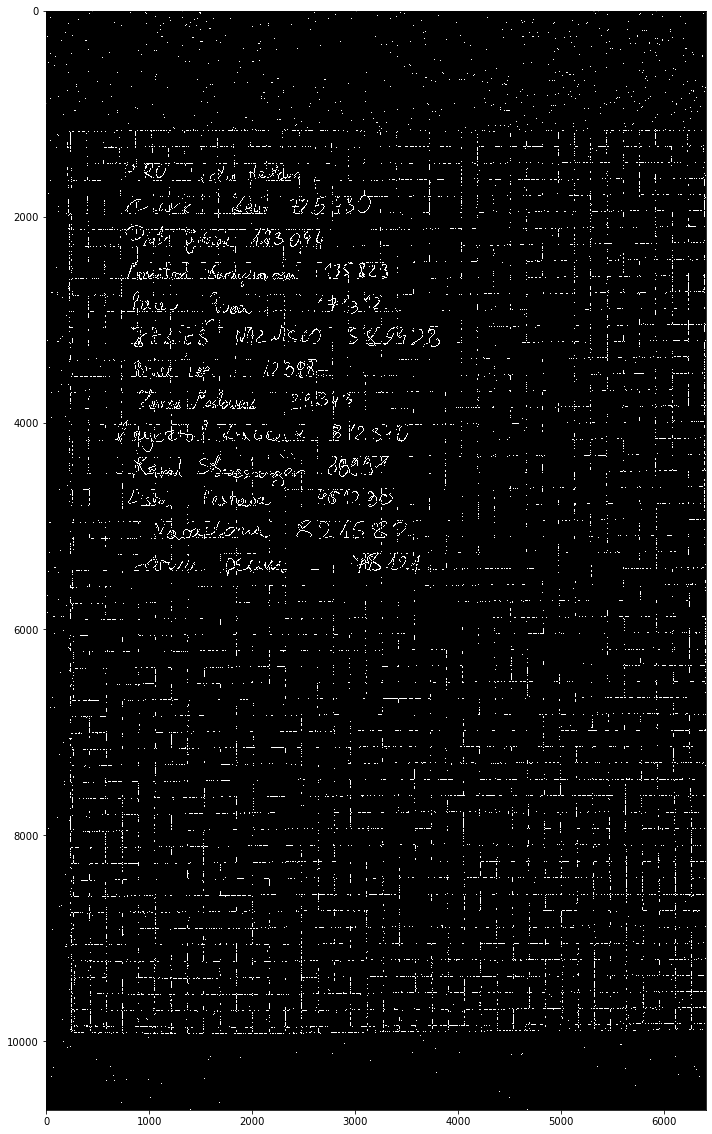

In [89]:
test = grid.copy()
test = erode(test, 2)
test = dilate(test, 2)
debug_plot_cv_img(test, cmap='gray')